In [9]:
from __future__ import print_function
import argparse
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR


In [10]:
class CnnNet(nn.Module):
    def __init__(self):
        super(CnnNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(2704, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
    
    

In [11]:
def train( model, device, train_loader, optimizer,loss_fn, epoch):
    train_loss=0
    model.train()
    no_batches=0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        #print(data.shape)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        #train_loss.append(sum(loss.detach().cpu().numpy())/len(data))
        train_loss+=loss.item()
        no_batches+=1
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        #if batch_idx % 10 == 0:
        #    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #        epoch, batch_idx * len(data), len(train_loader.dataset),
        #        100. * batch_idx / len(train_loader), loss.item()))
    print("Epoch:", epoch, "sum loss:", train_loss, "batches", no_batches, "loss:", train_loss/no_batches,
         "accuracy:", 100. * correct / len(train_loader.dataset))  
    return train_loss/no_batches, 100. * correct / len(train_loader.dataset)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target)  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, 100. * correct / len(test_loader.dataset)



In [12]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1)

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': 512}
test_kwargs = {'batch_size': 512}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform=transforms.Compose([
        transforms.ToTensor()
        #transforms.Normalize((0.1307,), (0.3081,))
        ])
dataset1 = datasets.MNIST('../data', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('../data', train=False, transform=transform)
print(type(dataset1))
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)


<class 'torchvision.datasets.mnist.MNIST'>


In [13]:
train_data=[]
train_labels=[]
print(len(train_loader))
for data, label in train_loader:
    #data, label= dataset1[i]
    for dt in data: 
        train_data.append(dt)
    for lb in label:
        train_labels.append(lb)
print(len(train_data))    
print(len(train_labels))
print()
#print(train_data[0])   




118
60000
60000



In [14]:
import random
random.shuffle(train_labels)

train_data_shuffle = []
for i in range(len(train_data)):
    train_data_shuffle.append([train_data[i], train_labels[i]])

train_loader_shuffle = torch.utils.data.DataLoader(train_data_shuffle, shuffle=True, batch_size=512)


In [15]:
def returnModelAccAndLoss(model, device, train_loader, test_loader, optimizer, loss, epoch, scheduler):
    train_loss=[]
    test_loss=[]
    accuracy_train=[]
    accuracy_test=[]
    #print("test_loader_size:", len(test_loader.dataset))
    for epoch in range(1, epoch+1):
        tr_loss, tr_accuracy=train(model, device, train_loader, optimizer, loss, epoch)
        train_loss.append(tr_loss)
        accuracy_train.append(tr_accuracy)
        tst_loss, tst_accuracy = test(model, device, test_loader)
        test_loss.append(tst_loss)
        accuracy_test.append(tst_accuracy)
        scheduler.step()
    return train_loss, accuracy_train, test_loss, accuracy_test



In [16]:
epoch=100
model = CnnNet().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=1)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)
loss = nn.CrossEntropyLoss()
train_loss_1, accuracy_train_1, test_loss_1, test_accuracy_1= returnModelAccAndLoss(model, device, train_loader_shuffle, test_loader, optimizer, loss, epoch, scheduler)

#torch.save(model.state_dict(), "mnist_cnn.pt")
  
    

Epoch: 1 sum loss: 271.75069546699524 batches 118 loss: 2.3029719954830106 accuracy: 11.111666666666666

Test set: Average loss: 2.3023, Accuracy: 1135/10000 (11%)

Epoch: 2 sum loss: 271.5525965690613 batches 118 loss: 2.3012931912632313 accuracy: 11.236666666666666

Test set: Average loss: 2.3022, Accuracy: 1135/10000 (11%)

Epoch: 3 sum loss: 271.544873714447 batches 118 loss: 2.3012277433427712 accuracy: 11.236666666666666

Test set: Average loss: 2.3022, Accuracy: 1135/10000 (11%)

Epoch: 4 sum loss: 271.53723311424255 batches 118 loss: 2.301162992493581 accuracy: 11.236666666666666

Test set: Average loss: 2.3022, Accuracy: 1135/10000 (11%)

Epoch: 5 sum loss: 271.55051279067993 batches 118 loss: 2.3012755321244063 accuracy: 11.236666666666666

Test set: Average loss: 2.3022, Accuracy: 1135/10000 (11%)

Epoch: 6 sum loss: 271.5427701473236 batches 118 loss: 2.3012099165027426 accuracy: 11.236666666666666

Test set: Average loss: 2.3022, Accuracy: 1135/10000 (11%)

Epoch: 7 sum lo

Epoch: 51 sum loss: 271.53859663009644 batches 118 loss: 2.3011745477126815 accuracy: 11.236666666666666

Test set: Average loss: 2.3022, Accuracy: 1135/10000 (11%)

Epoch: 52 sum loss: 271.53775119781494 batches 118 loss: 2.30116738303233 accuracy: 11.236666666666666

Test set: Average loss: 2.3022, Accuracy: 1135/10000 (11%)

Epoch: 53 sum loss: 271.54316997528076 batches 118 loss: 2.3012133048752608 accuracy: 11.236666666666666

Test set: Average loss: 2.3022, Accuracy: 1135/10000 (11%)

Epoch: 54 sum loss: 271.5411744117737 batches 118 loss: 2.301196393320116 accuracy: 11.236666666666666

Test set: Average loss: 2.3022, Accuracy: 1135/10000 (11%)

Epoch: 55 sum loss: 271.533567905426 batches 118 loss: 2.3011319314019154 accuracy: 11.236666666666666

Test set: Average loss: 2.3022, Accuracy: 1135/10000 (11%)

Epoch: 56 sum loss: 271.53621435165405 batches 118 loss: 2.3011543589123225 accuracy: 11.236666666666666

Test set: Average loss: 2.3022, Accuracy: 1135/10000 (11%)

Epoch: 57 

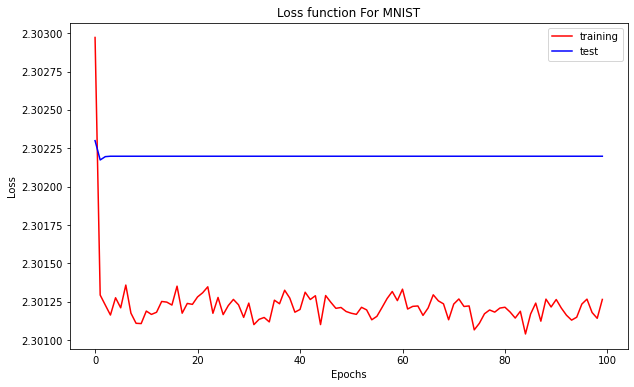

In [17]:
import matplotlib.pyplot as plt
plt1=plt.figure(figsize=(10, 6))
plt.plot(np.array(train_loss_1), 'r', label='training')
plt.plot(np.array(test_loss_1), 'b', label='test')

# naming the x axis
plt.xlabel('Epochs')
# naming the y axis
plt.ylabel('Loss') 
plt.legend()
plt.title("Loss function For MNIST")
plt.show()


